Детектор аномалии на принципе многократной прогонки реконструкции входного образца до сходимости латентного вектора.
Критерий аномальности - расстояние от первоначального латентного вектора до сошедшего.

In [2]:
from dataclasses import dataclass
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy import FuzzyLayer, DefuzzyLinearLayer, FuzzyBellLayer
import piqa
import sklearn.metrics as metrics
from sklearn.manifold import TSNE
from torchvision.transforms import v2

In [3]:
batch_size = 128
learning_rate = 2e-3
num_epochs = 25
latent_dim = 7
mnist_class_anomaly = 4
kernels = 16
fuzzy_rules_count = 8

prefix = f"fuzzy_cvae_mamdani_anomaly"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ssim = piqa.SSIM(window_size = 11, n_channels=1, reduction='none').to(device)

## Датасет

1. Исключаем класс аномалии `mnist_class_anomaly` из общей выборк
2. Убираем метки с остальных классов
   

In [4]:
def norm_and_transform(x):
    nimg = 2.0*(x.view(-1, 28, 28) - 0.5)
    nimg = torch.clamp(nimg, -1, 1)
    return nimg

def clamp(x):
    #nimg = 2.0*(x.view(-1, 28, 28) - 0.5)
    nimg = torch.clamp(x, -1, 1)
    return nimg

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(norm_and_transform)
])

augmentation = transforms.Compose([
    transforms.RandomRotation(15, fill=-1), 
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), fill=-1), 
    #transforms.RandomCrop(size=26),
    #transforms.Resize(size=(28, 28)),
    transforms.Lambda(clamp)
])

In [5]:
def get_target_and_mask(target_label):
    t = target_label
    return t 

train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)

idx = (train_data.targets != mnist_class_anomaly)
train_data.targets = train_data.targets[idx]
train_data.data = train_data.data[idx]
len(train_data)

54158

загружаем тестовую выборку

In [6]:
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)
len(test_data)

10000

Создаем итераторы датасетов

In [7]:

train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

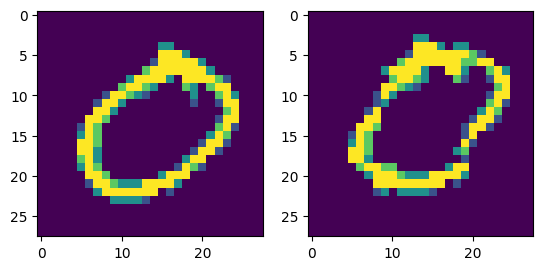

In [8]:
for data,_ in iter(train_loader):
    R, C = 1, 2
    plt.subplot(R, C, 1)
    plt.imshow(data[0].squeeze())
    plt.subplot(R, C, 2)
    plt.imshow(augmentation(data)[0].squeeze())
    
    
    break

## Модель

In [9]:
class TermAverageActivationStatsLayer(torch.nn.Module):
    def __init__(self, terms_count, alpha=1e-2):
        """
        """
        super().__init__()
        #self.dummy = torch.nn.Parameter(torch.empty(0))
        self.terms_count = terms_count
        self.alpha = alpha
        self.accumulated_average_activation = None
        

    def forward(self, x):
        """
        """
        ava = x.mean(0)
        if self.accumulated_average_activation is None:
            self.accumulated_average_activation = ava
        else:
            self.accumulated_average_activation = (1 - self.alpha) * self.accumulated_average_activation + self.alpha * ava

        return x

    def get_norm_stats(self, eps=1e-7):
        """
        
        """
        s = self.accumulated_average_activation.sum() + eps
        return (self.accumulated_average_activation / s).detach()

In [10]:
class TermLatentSpaceCentroidTrackingLayer(torch.nn.Module):
    def __init__(self, latent_dim, alpha=1e-3):
        """
        """
        super().__init__()
        #self.dummy = torch.nn.Parameter(torch.empty(0))
        self.latent_dim = latent_dim
        self.alpha = alpha
        self.aver_centroid = None

    def forward(self, latent_vectors):
        """
        """
        avc = latent_vectors.mean(0)
        if self.aver_centroid is None:
            self.aver_centroid = avc
        else:
            self.aver_centroid = (1 - self.alpha) * self.aver_centroid + self.alpha * avc
        return latent_vectors

    def get_average_centroid(self):
        """
        
        """
        return self.aver_centroid.detach()

In [11]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.SiLU()]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class Encoder(nn.Module):
    """
    Компонент энкодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim, kernels):
        super(Encoder, self).__init__()
                
        self.conv1 = conv_block(1, 2*kernels)
        self.conv2 = conv_block(2*kernels, 4*kernels, pool=True)
        self.res1 = nn.Sequential(conv_block(4*kernels, 4*kernels), conv_block(4*kernels, 4*kernels))
        
        self.conv3 = conv_block(4*kernels, 8*kernels, pool=True)
        self.conv4 = conv_block(8*kernels, 16*kernels, pool=True)
        self.res2 = nn.Sequential(conv_block(16*kernels, 16*kernels), conv_block(16*kernels, 16*kernels))

        #self.after_sum = nn.SiLU()
        #self.softplus = nn.Softplus()
        self.latent = nn.Sequential(
            nn.Conv2d(16*kernels, latent_dim, 3),
            nn.BatchNorm2d(latent_dim, track_running_stats=True),
            nn.Tanh(),
            nn.Flatten(),
            #nn.Linear(16*kernels*9, latent_dim), # mean + variance.
        )

         
    def forward(self, x):
        """
        Выход энкодера для чистого VAE.
        
        Args:
            x (torch.Tensor): Входной вектор.
            eps (float): Небольшая поправка к скейлу для лучшей сходимости и устойчивости.
        
        Returns:
            mu, logvar, z, dist
        """

        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out) + out

        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out

        out = self.latent(out)

        return out

In [12]:
inp = torch.rand(10, 1, 28, 28)
m = Encoder(latent_dim, 2)
mu = m.forward(inp)
mu[0].shape

torch.Size([7])

In [14]:
class Decoder(nn.Module):
    """
    Компонент декодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim, fuzzy_rules_count, kernels):
        super(Decoder, self).__init__()

        scale = 2
        initial_centroids = 2 * scale * (0.5 - np.random.rand(fuzzy_rules_count, latent_dim))
        initial_scales = scale * np.ones((fuzzy_rules_count, latent_dim))
        self.fuzzy = nn.Sequential(
            TermLatentSpaceCentroidTrackingLayer(latent_dim),
            FuzzyLayer.from_centers_and_scales(initial_centroids, initial_scales, trainable=True),
            TermAverageActivationStatsLayer(fuzzy_rules_count),
            #nn.BatchNorm1d(fuzzy_rules_count, track_running_stats=False),
            #nn.SiLU()
        )
        
        self.input = nn.Sequential(
            nn.Unflatten(1, (fuzzy_rules_count, 1, 1)),
            nn.BatchNorm2d(fuzzy_rules_count, track_running_stats=True),
            nn.SiLU(),
        )

        self.block_1 = nn.Sequential(
            nn.ConvTranspose2d(fuzzy_rules_count, 16*kernels, 4),
            nn.BatchNorm2d(16*kernels, track_running_stats=True),
            nn.SiLU(), 
            nn.ConvTranspose2d(16*kernels, 16*kernels, 4),
            nn.BatchNorm2d(16*kernels, track_running_stats=True),
            nn.SiLU(), 
        )

        self.block_2 = nn.Sequential(
            nn.ConvTranspose2d(16*kernels, 8*kernels, 4),
            nn.BatchNorm2d(8*kernels, track_running_stats=True),
            nn.SiLU(), 
            nn.ConvTranspose2d(8*kernels, 8*kernels, 4),
            nn.BatchNorm2d(8*kernels, track_running_stats=True),
            nn.SiLU(), 
        )

        self.block_3 = nn.Sequential(
            nn.ConvTranspose2d(8*kernels, 4*kernels, 4),
            nn.BatchNorm2d(4*kernels, track_running_stats=True),
            nn.SiLU(), 
            nn.ConvTranspose2d(4*kernels, 4*kernels, 4),
            nn.BatchNorm2d(4*kernels, track_running_stats=True),
            nn.SiLU(), 
        )

        self.block_4 = nn.Sequential(
            nn.ConvTranspose2d(4*kernels, 2*kernels, 4),
            nn.BatchNorm2d(2*kernels, track_running_stats=True),
            nn.SiLU(), 
            nn.ConvTranspose2d(2*kernels, 2*kernels, 4),
            nn.BatchNorm2d(2*kernels, track_running_stats=True),
            nn.SiLU(), 
        )

        self.block_5 = nn.Sequential(
            nn.ConvTranspose2d(2*kernels, kernels, 2),
            nn.BatchNorm2d(kernels, track_running_stats=True),
            nn.SiLU(), 
            nn.ConvTranspose2d(kernels, kernels, 2),
            nn.BatchNorm2d(kernels, track_running_stats=True),
            nn.SiLU(), 
        )

        self.output = nn.Sequential(
            nn.ConvTranspose2d(kernels, 1, 2),
            nn.Tanh() 
        )
        self.upscale_1 = nn.Sequential(nn.ConvTranspose2d(fuzzy_rules_count, 16*kernels, kernel_size=7))
        self.upscale_2 = nn.Sequential(nn.ConvTranspose2d(16*kernels, 8*kernels, kernel_size=7))
        self.upscale_3 = nn.Sequential(nn.ConvTranspose2d( 8*kernels, 4*kernels, kernel_size=7))
        self.upscale_4 = nn.Sequential(nn.ConvTranspose2d( 4*kernels, 2*kernels, kernel_size=7))
        self.upscale_5 = nn.Sequential(nn.ConvTranspose2d( 2*kernels, kernels,   kernel_size=3))
        self.after_sum = nn.SiLU()
         
    def forward(self, z):
        """
        Декодирует латентный вектор в исходное представление
        
        Args:
            z (torch.Tensor): Латентный вектор.
        
        Returns:
            x
        """
        fz = self.fuzzy(z)
        mapx = self.input(fz)

        x = self.decode_from_mp(mapx)
        return x, fz, mapx
    
    def decode_from_fz(self, fz):
        mapx = self.input(fz)
        x = self.decode_from_mp(mapx)
        return x

    def decode_from_mp(self, x):
        res = self.upscale_1(x)
        #print(res.shape)
        x = self.block_1(x)
        #print(x.shape)
        x = self.after_sum(x+res)

        res = self.upscale_2(x)
        #print(res.shape)
        x = self.block_2(x)
        #print(x.shape)
        x = self.after_sum(x+res)

        res = self.upscale_3(x)
        x = self.block_3(x)
        x = self.after_sum(x+res)

        res = self.upscale_4(x)
        x = self.block_4(x)
        x = self.after_sum(x+res)

        res = self.upscale_5(x)
        x = self.block_5(x)
        x = self.after_sum(x+res)
        
        return self.output(x)
    
inp = torch.rand(10, latent_dim)
m = Decoder(latent_dim, fuzzy_rules_count, 8)
mu = m.forward(inp)
mu[0].shape

torch.Size([10, 1, 28, 28])

In [ ]:
class VAE(nn.Module):
    """
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    def __init__(self, latent_dim, fuzzy_rules_count, kernels):
        super(VAE, self).__init__()

        self.encoder = Encoder(latent_dim, kernels)        
        self.decoder = Decoder(latent_dim, fuzzy_rules_count, 2*kernels)
        #self.resd = Decoder(latent_dim, fuzzy_rules_count)
        

    def forward(self, x):
        """
        
        """
        mu = self.encoder(x)
        x_recon, fz, _ = self.decoder(mu)
        
        return mu, x_recon, fz
    
    def half_pass(self, x):
        """
        
        """
        mu = self.encoder(x)
        return mu
    
    def decoder_pass(self, x):
        r, f, _ = self.decoder(x)
        return r, f

## Обучение

In [ ]:
model = VAE(latent_dim=latent_dim, fuzzy_rules_count=fuzzy_rules_count, kernels=kernels).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

In [ ]:
#optimizer = torch.optim.Adam(list(model.encoder.parameters()) + list(model.decoder.parameters()), lr=learning_rate)
#optimizer_d = torch.optim.Adam(model.delta_decoder.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs=num_epochs, steps_per_epoch=len(train_loader))

In [ ]:
def tarctanh(x):
    return 0.5 * torch.log((1+x)/(1-x))

def log_norm_const(x, eps = 1e-6):
    # numerically stable computation
    x = torch.clamp(x, eps, 1 - eps)
    x = torch.where((x < 0.49) | (x > 0.51), x, 0.49 *
            torch.ones_like(x))
    return torch.log((2 * tarctanh(1 - 2 * x)) /
                    (1 - 2 * x) + eps)

def xent_continuous_ber(recon_x, x, pixelwise=False):
    ''' p(x_i|z_i) a continuous bernoulli '''
    eps = 1e-6
    if pixelwise:
        return (x * torch.log(recon_x + eps) +
                        (1 - x) * torch.log(1 - recon_x + eps) +
                        log_norm_const(recon_x, eps))
    else:
        return torch.mean(torch.sum(x * torch.log(recon_x + eps) +
                        (1 - x) * torch.log(1 - recon_x + eps) +
                        log_norm_const(recon_x, eps), dim=(1, )), dim=(1, 2))
    

a = -torch.ones(3, 1, 28, 28)
b = -torch.ones(3, 1, 28, 28)

xent_continuous_ber((a + 1)/2, (b + 1)/2)

In [ ]:
def compute_vae_loss(x, recon_x):
    
    loss_recon = (x - recon_x).square().sum(-1).sum(-1).mean()
    #loss_recon = -xent_continuous_ber((recon_x + 1)/2, (x + 1)/2)
    #loss_recon = loss_recon.mean()
    #loss_recon = (1 - ssim((recon_x + 1)/2, (x + 1)/2))
    #loss_recon = loss_recon.mean()
    
    #raw_loss_recon = (1 - diff).square() #F.binary_cross_entropy((recon_x+1)/2, (x + 1)/2, reduction='none').sum(-1).mean()#
    #loss_recon = raw_loss_recon.mean()
    
    return loss_recon #(x-recon_x).square().sum(-1).sum(-1).mean()
    

In [ ]:
def compute_fuzzy_loss(fuzzy, z, fz):
    
    iid = torch.cdist(z, fuzzy.get_centroids()).min(-1).indices.reshape(-1, 1)
    winners = torch.gather(fz, 1, iid).squeeze()
    
    return (1 - winners).clamp(min=0.5).square().mean() + (1 - fz.sum(-1)).square().mean() #(0.999 - (tops[:,0]+tops[:,1]).clamp(max=0.999)).mean() + tops[:, 2].clamp(min=0.001).mean()

In [ ]:
def compute_centroids_loss(fuzzy_layer):
    
    c = fuzzy_layer[1].get_centroids()
    c = c.mean(0)
    ac = fuzzy_layer[0].get_average_centroid()

    return (c-ac).square().mean()


In [ ]:
eigens = model.decoder.fuzzy[1].get_transformation_matrix_eigenvals().real


In [ ]:
def compute_fshape_loss(fuzzy_layer):
    
    eigens = fuzzy_layer.get_transformation_matrix_eigenvals().real
    fz_volume = (0.1 - eigens).square()
    fz_volume = fz_volume.mean()
    
    #fz_scales = (1 - eigens).square().mean()

    return fz_volume
    

In [ ]:
def keep_eigenvals_positive_loss(layer, eps = 1e-15):
    ev = layer.get_transformation_matrix_eigenvals().real.min()
    ev = torch.clamp(ev, max=eps)
    return -ev

In [ ]:
def get_arate(inp):
    _, x_recon, _ = model.forward(inp)
    
    # prev_mu = mu
    # sum = torch.zeros_like(mu)
    
    # for i in range(20):
    #     recon_x = model.decoder_pass(mu)
    #     mu, _, _ = model.half_pass(recon_x)
    #     sum += (mu - prev_mu).abs()
    #     prev_mu = mu
    # +
    return (1 - ssim((x_recon + 1)/2, (inp + 1)/2)).cpu().numpy()#xent_continuous_ber((x_recon + 1)/2, (inp + 1)/2).cpu().numpy()# #ssim((inp + 1)/2, (recon_x+1)/2).cpu().numpy() #fz.sum(-1).cpu().numpy()#

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def train(model, dataloader, optimizer, sched, prev_updates, epoch, writer=None):
    model.train()  
    
    for batch_idx, (data, _) in enumerate(tqdm(dataloader, disable=True)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        adata = augmentation(data)
        
        optimizer.zero_grad()  
        z = model.half_pass(adata)  
        x_reconstruct, _ = model.decoder_pass(z)
        #x_resd, _ = model.resd_pass(z)
        loss_reconstruct = compute_vae_loss(data, x_reconstruct)
        #loss_resd = compute_vae_loss((data - x_reconstruct).abs(), x_resd)
        #fz_loss = compute_fuzzy_loss(model.decoder.fuzzy[1], z, fz)
        #fz_volume = compute_fshape_loss(model.decoder.fuzzy[1])
        
        ev_loss = keep_eigenvals_positive_loss(model.decoder.fuzzy[1])
        if ev_loss.item() > 0:
            ev_loss.backward(retain_graph=True)
        
        #fz_loss.backward(retain_graph=True)
        #fz_volume.backward(retain_graph=True)
        (loss_reconstruct).backward()
        #loss_resd.backward() 
        
        optimizer.step()  
        
        sched.step()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
    if writer is not None:
        writer.add_scalar('ADFVAE/LR', get_lr(optimizer), global_step=epoch)
        
    return prev_updates + len(dataloader)

In [ ]:
def shannon_entropy(fuzzy):
    distr = fuzzy[2].get_norm_stats()
    dim = distr.shape[0]
    return np.log(dim) + (distr*distr.log()).sum()

In [ ]:
fixed_random_z = torch.randn(16, latent_dim).to(device)

def test(model, dataloader, cur_step, epoch, writer=None):
    model.eval() 
    test_recon_loss = 0
    test_kl_loss = 0
    test_fz_loss = 0
    test_fzvol_loss = 0
    test_c_loss = 0
    
    lab_true = []
    lab_pred = []

    with torch.no_grad():
        for data, lab in tqdm(test_loader, desc='Test MNIST', disable=True):
            data = data.view((-1,1,28,28)).to(device)
            rates = get_arate(data)
            
            for f, l in  zip(rates, lab):
                lab_pred.append(f)        
                if l == mnist_class_anomaly:
                    lab_true.append(1)
                else:
                    lab_true.append(0)
                        
    fpr, tpr, _ = metrics.roc_curve(lab_true, lab_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    embedings = []
    labels_expected = []
    centroids = model.decoder.fuzzy[1].get_centroids().detach().cpu().numpy()
    #centroids_resd = model.resd.fuzzy[1].get_centroids().detach().cpu().numpy()
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing', disable=True):
            data = data.to(device)
            z = model.half_pass(data)  
            x_reconstruct, fz = model.decoder_pass(z)
            #x_resd, _ = model.resd_pass(z)
            
            embedings.append(z.cpu().numpy())
            labels_expected.append(target.cpu().numpy())

            loss_recon = compute_vae_loss(data, x_reconstruct)
            #loss_resd = compute_vae_loss((data - x_reconstruct).abs(), x_resd)
            fz_volume = compute_fshape_loss(model.decoder.fuzzy[1])
            c_loss = compute_centroids_loss(model.decoder.fuzzy)    
            fz_loss = compute_fuzzy_loss(model.decoder.fuzzy[1], z, fz)

            test_recon_loss += loss_recon.item()
            #test_kl_loss += loss_resd.item()
            test_fz_loss += fz_loss.item()
            test_fzvol_loss += fz_volume.item()
            test_c_loss += c_loss.item()

    embedings = np.concatenate(embedings, axis=0)
    labels_expected = np.concatenate(labels_expected, axis=0)

    if epoch % 5 == 1:
        plt.figure(figsize=(18, 6))

        R, C = 1, 3

        plt.subplot(R, C, 1)
        plt.title("MNIST XY")
        plt.scatter(embedings[:, 0],      embedings[:,  1], c=labels_expected, cmap='tab10', s=2)
        plt.scatter(centroids[:, 0],      centroids[:, 1], marker='1', c='black', s= 50)
        #plt.scatter(centroids_resd[:, 0],      centroids_resd[:, 1], marker='2', c='red', s= 20)
        
        # plt.xlim((-1, 1))
        # plt.ylim((-1, 1))

        plt.subplot(R, C, 2)
        plt.title("MNIST XZ")
        plt.scatter(embedings[:, 0],      embedings[:,  2], c=labels_expected, cmap='tab10', s=2)
        plt.scatter(centroids[:, 0],      centroids[:, 2], marker='1', c='black', s= 50)
        #plt.scatter(centroids_resd[:, 0], centroids_resd[:, 2], marker='2', c='red', s= 20)
        
        # plt.xlim((-1, 1))
        # plt.ylim((-1, 1))

        plt.show()
    
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    test_fz_loss /= len(dataloader)
    test_fzvol_loss /= len(dataloader)
    test_c_loss /= len(dataloader)
    print(f'[{cur_step}] Reconstruction loss: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f} AUC {roc_auc:.4f} FZ {test_fz_loss:.4f} FZVOL {test_fzvol_loss:.4f} CENTROIDS DISCREPANCY {test_c_loss:.4f} SHANNON {shannon_entropy(model.decoder.fuzzy)}')
    #print(f'Average activation stats: {model.decoder.fuzzy[2].get_norm_stats()}')
    #print(f'Average centroid stats: {model.decoder.fuzzy[0].get_average_centroid()}')
    if writer is not None:
        writer.add_histogram('ADFVAE/TermActivation', model.decoder.fuzzy[2].get_norm_stats(), cur_step)
        writer.add_scalar('ADFVAE/AUC', roc_auc, global_step=cur_step)
        writer.add_scalar('ADFVAE/Reconstruction', test_recon_loss, global_step=cur_step)
        writer.add_scalar('ADFVAE/KLD', test_kl_loss, global_step=cur_step)
        writer.add_scalar('ADFVAE/Fuzzy', test_fz_loss, global_step=cur_step)
        writer.add_scalar('ADFVAE/Fuzzy/Vol', test_fzvol_loss, global_step=cur_step)
        writer.add_scalar('ADFVAE/Fuzzy/CDist', test_c_loss, global_step=cur_step)
        
        samples, _ = model.decoder_pass(fixed_random_z)
        #samples_resd, _ = model.resd_pass(fixed_random_z)
        writer.add_images('ADFVAE/Samples', samples.view(-1, 1, 28, 28), global_step=cur_step)
        #writer.add_images('ADFVAE/ResdSamples', samples_resd.view(-1, 1, 28, 28), global_step=cur_step)

In [ ]:
prev_updates = 0

In [ ]:
for epoch in range(num_epochs):
    prev_updates = train(model, train_loader, optimizer, sched, prev_updates, epoch, writer=writer)
    test(model, test_loader, prev_updates, epoch, writer=writer)
    


In [ ]:
keep_eigenvals_positive_loss(model.decoder.fuzzy[1])

## Визуализируем результаты

In [ ]:

def get_activation_stats(model, dataloader):
    rulestat = {}
    with torch.no_grad():
        for _, (data, _) in enumerate(tqdm(dataloader)):
            data = data.to(device)
            _, _, fz = model.forward(data)
            act_fz = fz.max(-1).indices.cpu().numpy()
            for ind in act_fz:
                rulestat[ind] = rulestat.get(ind, 0) + 1
    return rulestat

train_stat = get_activation_stats(model, train_loader)
test_stat = get_activation_stats(model, test_loader)

plt.bar(list(train_stat.keys()), train_stat.values(), 0.5, color='g')
plt.bar(list(test_stat.keys()), test_stat.values(), 0.5, color='r')

In [ ]:
# from sklearn.ensemble import IsolationForest
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import ConfusionMatrixDisplay
# from sklearn.metrics import accuracy_score

# train_x = []
# test_x = []
# test_y = []
# with torch.no_grad():
#     for _, (data, _) in enumerate(tqdm(train_loader)):
#         data = data.to(device)
#         fz, _, _ = model.forward(data)
#         for f in fz:
#             train_x.append(f.cpu().numpy())

# with torch.no_grad():
#     for _, (data, target) in enumerate(tqdm(test_loader)):
#         data = data.to(device)
#         fz, _, _  = model.forward(data)
#         for f, trg in zip(fz, target):
#             test_x.append(f.cpu().numpy())
#             if trg == mnist_class_anomaly:
#                 test_y.append(-1)
#             else:
#                 test_y.append(1)
    
# clf = IsolationForest(random_state=0, n_estimators=1000).fit(train_x)
# y_pred =clf.predict(test_x)
# disp = ConfusionMatrixDisplay(confusion_matrix(test_y, y_pred))
# disp.plot()
# accuracy_score(test_y, y_pred)

In [ ]:

def get_activation_stats_by_digit(digit, model, dataloader):
    rulestat = {}
    with torch.no_grad():
        for _, (data, target) in enumerate(tqdm(dataloader)):
        
            data = data.to(device)
            _, _, fz = model.forward(data)
            act_fz = fz.max(-1).indices.cpu().numpy()
            for ind, trg in zip(act_fz, target):
                if trg == digit:
                    rulestat[ind] = rulestat.get(ind, 0) + 1
    return rulestat


test_stat_by_digit = get_activation_stats_by_digit(9, model, test_loader)

plt.bar(list(test_stat_by_digit.keys()), test_stat_by_digit.values(), 0.5, color='r')
plt.xlim((-1, fuzzy_rules_count + 1))

In [ ]:
test_stat_by_digit

In [ ]:
z = torch.randn(64, latent_dim).to(device)
samples, _ = model.decoder_pass(z)

# Plot the generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[i, j].axis('off')


In [ ]:
# fz = torch.zeros(64, fuzzy_rules_count).to(device)
# for i in range(64):
#     fz[i][5] = 1.0/(i+1)

# samples = model.decoder.decode_from_fz(fz)

# # Plot the generated images
# fig, ax = plt.subplots(8, 8, figsize=(8, 8))
# for i in range(8):
#     for j in range(8):
#         ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
#         ax[i, j].axis('off')

# # plt.show()
# plt.savefig('cvae_mnist.webp')

In [ ]:
ssim = piqa.SSIM(window_size = 9, n_channels=1, reduction='none').to(device)
def get_arate(inp):
    _, x_recon, fz_1 = model.forward(inp)
    _, x_recon, fz_2 = model.forward(x_recon)
    
    return (fz_1 - fz_2).abs().sum(-1).cpu().numpy() #(1 - ssim((x_recon + 1)/2, (inp + 1)/2)).cpu().numpy()#xent_continuous_ber((x_recon + 1)/2, (inp + 1)/2).cpu().numpy()# (1 - ssim((x_recon + 1)/2, (inp + 1)/2)).cpu().numpy() #ssim((inp + 1)/2, (recon_x+1)/2).cpu().numpy() #fz.sum(-1).cpu().numpy()#

In [ ]:
firings_mnist = {}
firings_mnist['MNIST'] = []
firings_mnist['DISSIDENT'] = []

with torch.no_grad():
    for data, target in tqdm(test_loader, desc='MNIST HIST'):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate(data)
        for f, l in  zip(rates, target):
            if l != mnist_class_anomaly:
                firings_mnist['MNIST'].append(f)
            else:
                firings_mnist['DISSIDENT'].append(f)
        

labels, data = firings_mnist.keys(), firings_mnist.values()

fig = plt.figure(figsize =(12, 2))
plt.boxplot(data, notch=True, showfliers=False)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

writer.add_figure('Anomaly Detection', fig)

In [ ]:
with torch.no_grad():
    firing_levels = []
    lab_true = []
    lab_pred = []

    for data, lab in tqdm(test_loader, desc='Test MNIST', disable=True):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate(data)
        
        for f, l in  zip(rates, lab):
            firing_levels.append(f)
            lab_pred.append(f)        
            if l == mnist_class_anomaly:
                lab_true.append(1)
            else:
                lab_true.append(0)
                    
    fpr, tpr, threshold = metrics.roc_curve(lab_true, lab_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    fig = plt.figure(figsize =(4, 4))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    writer.add_figure('ROC', fig)

In [ ]:
def show_plot():
    centroids = model.decoder.fuzzy[1].get_centroids().detach().cpu().numpy()
    embedings = []
    labels_expected = []
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Encoding'):
            data = data.view((-1,1,28,28)).to(device)
            embeding,_,_ = model.forward(data)
            embedings.append(embeding.cpu().numpy())
            labels_expected.append(target.cpu().numpy())
    embedings = np.concatenate(embedings, axis=0)
    labels_expected = np.concatenate(labels_expected, axis=0)

    plt.figure(figsize=(18, 6))

    R, C = 1, 3

    plt.subplot(R, C, 1)
    plt.title("MNIST XY")
    plt.scatter(embedings[:, 0],      embedings[:,  1], c=labels_expected, cmap='tab10', s=2)
    #plt.scatter(centroids[:, 0],      centroids[:, 1], marker='1', c='black', s= 50)

    plt.subplot(R, C, 2)
    plt.title("MNIST XZ")
    plt.scatter(embedings[:, 0],      embedings[:,  2], c=labels_expected, cmap='tab10', s=2)
    #plt.scatter(centroids[:, 0],      centroids[:, 2], marker='1', c='black', s= 50)

    
show_plot()

In [ ]:
def show_item_reconstructio(ind):
    for data, trg in iter(test_loader):
        data = data.to(device)
        _, x_rec, fz = model.forward(data)
        #_, x_rec_2, fz_2 = model.forward(x_rec)

        plt.figure(figsize=(24, 6))

        R, C = 1, 6

        #plt.subplot(R, C, 1)
        #plt.imshow(fz[ind].detach().cpu().squeeze())
        #plt.bar(range(fuzzy_rules_count), fz[ind].detach().cpu().numpy(), color='g')
        #plt.bar(range(fuzzy_rules_count), fz_2[ind].detach().cpu().numpy(), color='r')
        plt.subplot(R, C, 1)
        plt.imshow(data[ind].cpu().squeeze())
        plt.subplot(R, C, 2)
        plt.imshow(x_rec[ind].detach().cpu().squeeze())
        #plt.subplot(R, C, 3)
        #plt.imshow(x_rec_2[ind].detach().cpu().squeeze())
        plt.subplot(R, C, 3)
        plt.imshow((x_rec[ind] - data[ind]).abs().detach().cpu().squeeze())
        #plt.subplot(R, C, 4)
        #plt.imshow(((data[ind]-x_rec[ind]).abs() - x_resd[ind]).abs().clamp(min=0.2).abs().detach().cpu().squeeze())
        break

In [ ]:
show_item_reconstructio(4)
show_item_reconstructio(3)